# scRNA-seq volcano plots

## Background

- volcano plots typically used but don't integrate distributional distances due to small number of replicates
- sRNA-seq data provides counts per cell so can use distributional metrics (KL divergence, Wasserstein distance)

## Methods

- Binary comparisons using
    - Mann-Whitney U tests
    - log2FC 
    - EMD
- Annotations to highlight biology

## Results

- can highlight genes and annotate per cluster


## Conclusions

- this will inform future analyses, perhaps as supplementary figures and binary comparisons to complement more complex interpretation of models

## Future directions

- TODO (@ngr, finish before using in diff prj): transfer updates from mouse to human
- TODO (@ngr, finish before using in diff prj): functionalize code for volcano plots
- TODO (@ngr, finish before publishing): quality-control for p-val NAs and using ranksumtests to circumvent mwu scipy bug from tiecorrect
- add different models, like neg. binomial regression (poisson regression, without requirement that mean=var)
    - neg. binomial reg. is approach taken by popular DESeq2 method in RNA-seq

## Contributions

NGR.200330

In [78]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [2]:

# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp

def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    Anndata.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if True :
    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = loader(fname,pdfp)
    
if True :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    %memit mdata = loader(fname,pdfp)


loaded @200328.17:57:25
took 25.34-s to load data
peak memory: 20560.15 MiB, increment: 20356.45 MiB
loaded @200328.17:59:53
took 147.73-s to load data
peak memory: 159629.35 MiB, increment: 149211.50 MiB


In [97]:
def mwu(X,Y,gene_names,correction=None,debug=False) :
    '''
    Benjamini-Hochberg correction implemented. Can change to Bonferonni

    gene_names (list)
    if X,Y single gene expression array, input x.reshape(-1,1), y.reshape(-1,1)

    NOTE: get zeros sometimes because difference (p-value is so small)
    '''
    p=pd.DataFrame()
    print('starting Mann-Whitney U w/Benjamini/Hochberg correction...\n')
    start = time.time()
    for i,g in enumerate(gene_names) :
        if i==np.round(np.quantile(np.arange(len(gene_names)),0.25)) :
            print('... 25% completed in {:.2f}-s'.format(time.time()-start))
        elif i==np.round(np.quantile(np.arange(len(gene_names)),0.5)) :
            print('... 50% completed in {:.2f}-s'.format(time.time()-start))
        elif i==np.round(np.quantile(np.arange(len(gene_names)),0.75)) :
            print('... 75% completed in {:.2f}-s'.format(time.time()-start))
        p.loc[i,'Gene']=g
        if (tiecorrect(rankdata(np.concatenate((np.asarray(X[:,i]),np.asarray(Y[:,i])))))==0) :
            if debug :
                print('P-value not calculable for {}'.format(g))
            p.loc[i,'pval']=np.nan
        else :
            _,p.loc[i,'pval']=mannwhitneyu(X[:,i],Y[:,i]) # continuity correction is True
    print('\n... mwu computed in {:.2f}-s\n'.format(time.time() - start))
    if True :
        # ignore NaNs, since can't do a comparison on these (change numbers for correction)
        p_corrected = p.loc[p['pval'].notna(),:]
        if p['pval'].isna().any():
            print('Following genes had NA p-val:')
            for gene in p['Gene'][p['pval'].isna()]:
                print('  %s' % gene)
    else : 
        p_corrected = p
    new_pvals = multipletests(p_corrected['pval'],method='fdr_bh')
    p_corrected['pval_corrected'] = new_pvals[1]
    return p_corrected

def log2aveFC(X,Y,gene_names,AnnData=None) :
    '''not sensitivity to directionality due to subtraction

    X and Y full arrays, subsetting performed here

    `gene_names` (list): reduced list of genes to calc

    `adata` (sc.AnnData): to calculate reduced list. NOTE: assumes X,Y drawn from adata.var_names
    '''
    if not AnnData is None :
        g_idx = [i for i,g in enumerate(AnnData.var_names) if g in gene_names]
        fc=pd.DataFrame({'Gene':AnnData.var_names[g_idx],
                         'log2FC':np.log2(X[:,g_idx].mean(axis=0)) - np.log2(Y[:,g_idx].mean(axis=0))}) # returns NaN if negative value 
    else :
        fc=pd.DataFrame({'Gene':gene_names,
                         'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
    return fc

In [57]:
genes_volcano = {'hum_OL':['DPYD', 'PPP2R2B', 'MBP', 'MOBP', 'NTM', 'S100B', 
                      'FGFR2', 'HAPLN2', 'PRKCA', 'MOG', 'ZEB2', 'PLP1', 
                      'ENPP6', 'MAG', 'CNP', 'CADM2', 'ERBB4', 'PLXDC2', 
                      'KCNIP4', 'NLGN1', 'NCAM2', 'HSPA1A', 'ZNF385D', 
                      'ANK3', 'FGF14', 'QDPR', 'CDH18', 'FCHSD2', 'LAMA2', 
                      'CCP110'],
                 'mouse_PC':['Grid2', 'Anks1b', 'Etl4', 'Fam107b', 
                       'Itpr1', 'Garnl3', 'Rgs8', 'Auts2', 'Col18a1', 
                       'Kcnip4', 'Car8', 'Kcnab1', 'Grid2ip', 'Cacna1a', 
                       'Kcnma1', 'Meg3', 'Pcdh9', 'Tenm2', 'Lsamp', 'Cntn5', 
                       'Lrp1b', 'Nlgn1', 'Lrrc4c', 'Xkr4', 'Sgcz', 'Pde1c', 
                       'Cntnap2', 'Nrxn3', 'Nrxn1', 'Asic2'],
                 'mouse_OL':['Dpyd','Ppp2r2b','Mbp','Mobp','Ntm','S100b','Fgfr2',
                             'Hapln2','Prkca','Mog','Zeb2','Plp1','Enpp6','Mag',
                             'Cnp','Cadm2','Erbb4','Plxdc2','Kcnip4','Nlgn1',
                             'Ncam2','Hspa1a','Ank3','Fgf14','Qdpr',
                             'Cdh18','Fchsd2','Lama2','Ccp110']}

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 36.97-s
... 50% completed in 82.84-s
... 75% completed in 139.93-s
... mwu computed in 208.40-s

... computed in 213.95-s


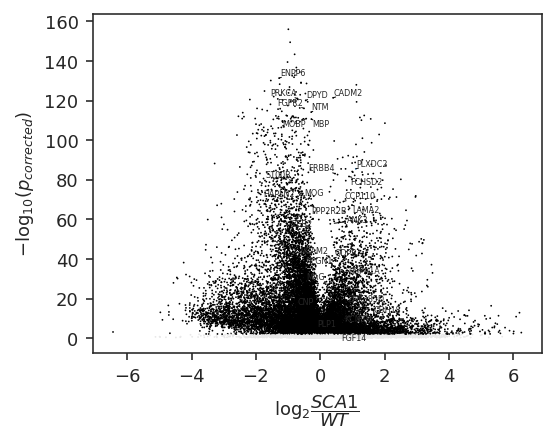

In [5]:
# human 
fname = 'hum_OL'

if True : 
    # not encoded yet
    hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
    
cluster='ctype'
groups = ['Oligodendrocyte']#hdata.obs[cluster].unique() # subset from which adata.obs var, `cluster=this var`?
dge = pd.DataFrame()
for i in groups :
    start = time.time()
    X = hdata.layers['imputed_bbknn'][(hdata.obs[cluster]==i) & (hdata.obs['genotype']=='WT') ,:]
    X_mut = hdata.layers['imputed_bbknn'][(hdata.obs[cluster]==i) & (hdata.obs['genotype']=='SCA1') ,:]
    
    p = mwu(X,X_mut,hdata.var_names)
    emd = scprep.stats.differential_expression(X_mut,X,
                                               measure = 'emd',
                                               direction='both', 
                                               gene_names=hdata.var_names,
                                               n_jobs=-1)
    emd['Gene']=emd.index
    emd=emd.drop(columns='rank')
    fc = log2aveFC(X_mut,X,hdata.var_names.to_list())
    dt = pd.merge(p,fc,how='left',on="Gene")
    dt = pd.merge(dt,emd,how='left',on='Gene')
    dt['Cell type']=[i]*len(hdata.var_names)
    dt['nlog10pvalcorrected']=(-1)*np.log10(dt['pval_corrected'])
    
    ## aesthetics
    cmap_volcano={'N.S.':'#E8E8E866','Up':'#d9534f','Down':'#428bca','B.H. cutoff':'#E8E8E8'}
    bonferonni_fulldata=0.01/3e5 # pval threshold
    dt['Significance']=['N.S.']*dt.shape[0]
    dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
    #     dt['Significance'][(dt['log2FC']>=1) & (dt['pval_corrected']<=bonferonni_fulldata)]='up'
    #     dt['Significance'][(dt['log2FC']<=-1) & (dt['pval_corrected']<=bonferonni_fulldata)]='down'
    dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Up'
    dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Down'

    ## plot
    fig,ax=plt.subplots(1,3,figsize=(12,3))
    p0=sns.scatterplot(x='log2FC',y='nlog10pvalcorrected',
                      data=dt,ax=ax[0],s=3,edgecolor='none',
                      palette=cmap_volcano,hue='Significance',legend=False,
                      rasterized=True)
    ax[0].plot([dt['log2FC'].min(),dt['log2FC'].max()],
            (-1)*np.log10([0.01,0.01]),
            'k--',lw=0.5) # BH cut off
    ax[0].set(xlabel='$\log_2 \dfrac{SCA1}{WT}$',ylabel='$-\log_{10}$($p_{corrected}$)')

    p1=sns.scatterplot(x='log2FC',y='emd',
                      data=dt,ax=ax[1],s=3,edgecolor='none',
                      palette=cmap_volcano,hue='Significance',legend=False,
                      rasterized=True)
    ax[1].set(xlabel='$\log_2 \dfrac{SCA1}{WT}$',ylabel='EMD(SCA1,WT)')

    p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                      data=dt,ax=ax[2],s=3,edgecolor='none',
                      palette=cmap_volcano,hue='Significance',legend=False,
                      rasterized=True)
    ax[2].plot([dt['emd'].min(),dt['emd'].max()],
            (-1)*np.log10([0.01,0.01]),
            'k--',lw=0.5) # BH cut off
    ax[2].set(xlabel='EMD(SCA1,WT)',ylabel='$-\log_{10}$($p_{corrected}$)')

    fig.tight_layout()

    ## annotate
    if False :
        ### pick genes w/mutual highest rank
        idx_up = (dt['nlog10pvalcorrected'][dt['Significance']=='up'].rank(ascending=False)+dt['log2FC'][dt['Significance']=='up'].rank(ascending=False)).sort_values().index[0:10]
        g_up = hdata.var_names[idx_up]
        g_up_x = dt['log2FC'][idx_up].to_list()
        g_up_y = dt['nlog10pvalcorrected'][idx_up].to_list()
        idx_down = (dt['nlog10pvalcorrected'][dt['Significance']=='down'].rank(ascending=False)+dt['log2FC'][dt['Significance']=='down'].rank(ascending=True)).sort_values().index[0:10]
        g_down = hdata.var_names[idx_down]
        g_down_x = dt['log2FC'][idx_down].to_list()
        g_down_y = dt['nlog10pvalcorrected'][idx_down].to_list()

        texts = [ax.text(g_up_x[i], g_up_y[i], g,fontsize=4) for i,g in enumerate(g_up)]
        adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.25))
        texts_down = [ax.text(g_down_x[i], g_down_y[i], g,fontsize=4) for i,g in enumerate(g_down)]
        adjust_text(texts_down,arrowprops=dict(arrowstyle="-", color='k', lw=0.25))
    else : 
        ### manually pick 
        idx_g={}
        for g in genes_volcano[fname]: # match fname with dict key
            idx_g[g]=[i for i,v in enumerate(hdata.var_names) if v==g][0] # assumes unique namees

        texts = [ax[0].text(dt['log2FC'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
        adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax[0])

        texts = [ax[1].text(dt['log2FC'][i],dt['emd'][i],g,fontsize=6) for g,i in idx_g.items()]
        adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax[1])

        texts = [ax[2].text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
        adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax[2])

    if True :
        # save plot
        fig.savefig(os.path.join(pfp,'volcano_{}.pdf'.format(fname)),dpi=300, bbox_inches='tight')
    
    dge = dge.append(dt, ignore_index=True)
    print('... computed in {:.2f}-s'.format(time.time()-start))
if True :
    # save volcano plot data
    dge.to_csv(os.path.join(pfp,'volcano_'+fname+'.csv'),index=False)



starting timepoint 5wk

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 31.46-s
... 50% completed in 70.83-s
... 75% completed in 119.34-s
... mwu computed in 176.71-s

... computed in 358.58-s

Finished timepoint 5wk in 6.53-min

starting timepoint 12wk

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 30.87-s
... 50% completed in 70.20-s
... 75% completed in 118.96-s
... mwu computed in 176.93-s

Following genes had NA p-val:
  Gm13398
  Fgb
  4921521D15Rik
  Gm35667
  Olfr805
  Gm28961
... computed in 237.29-s

Finished timepoint 12wk in 4.27-min

starting timepoint 18wk

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 33.68-s
... 50% completed in 75.49-s
... 75% completed in 126.64-s
... mwu computed in 186.88-s

... computed in 730.31-s

Finished timepoint 18wk in 12.83-min

starting timepoint 24wk

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 31.3

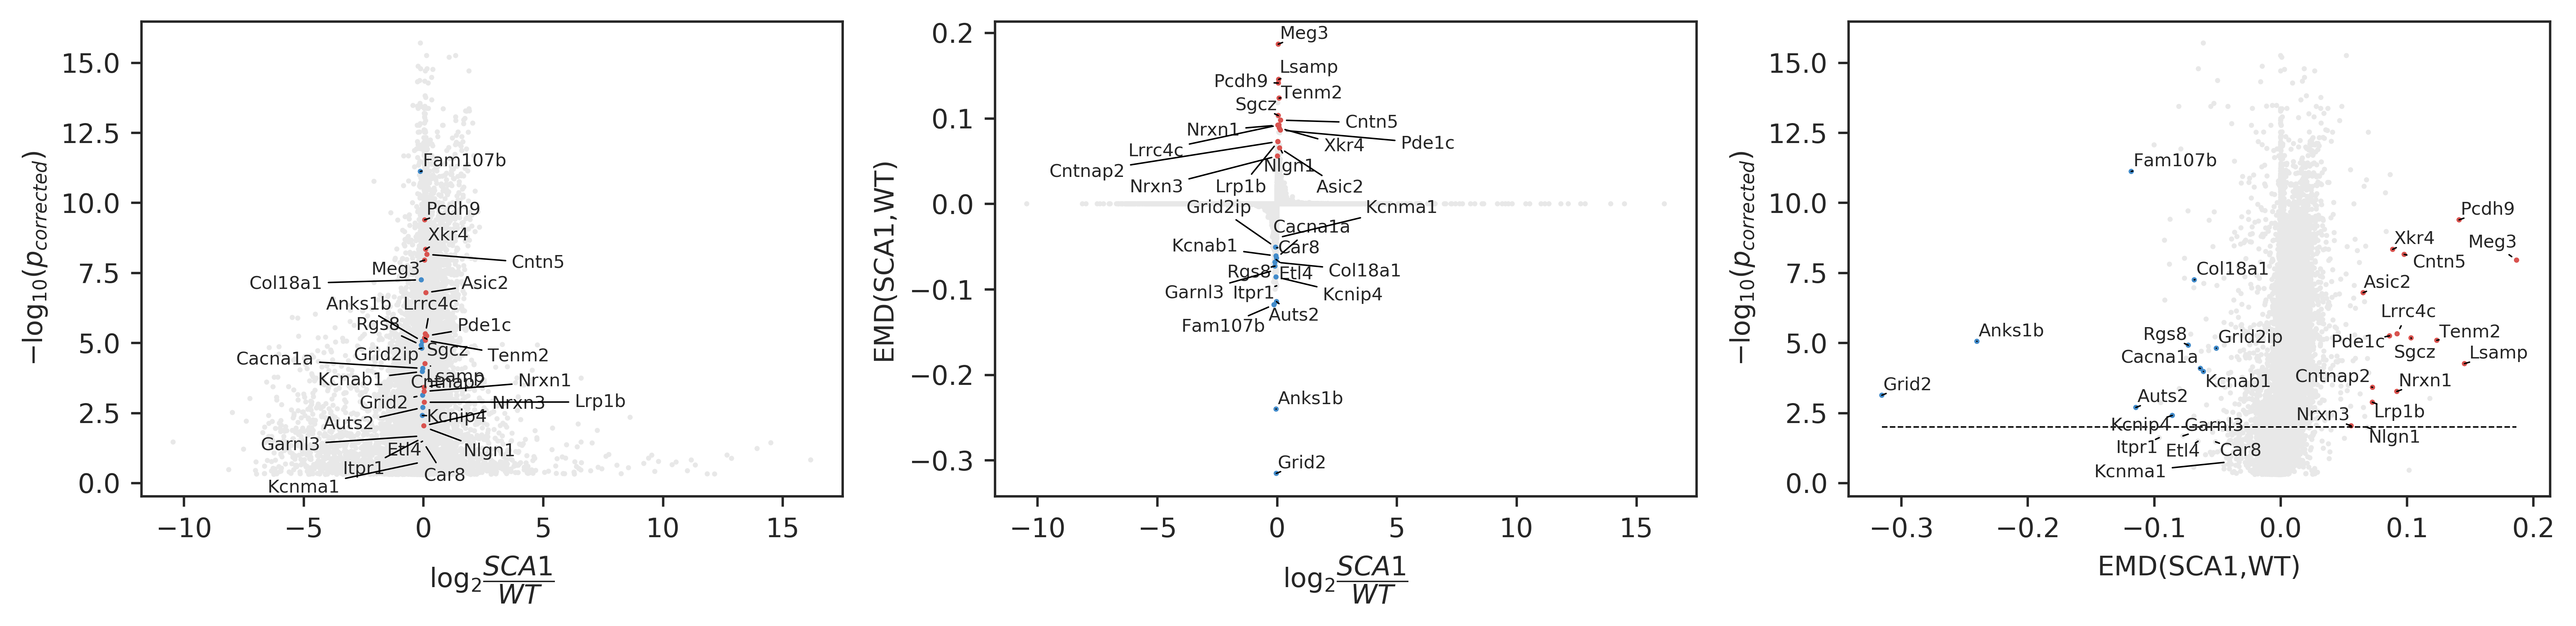

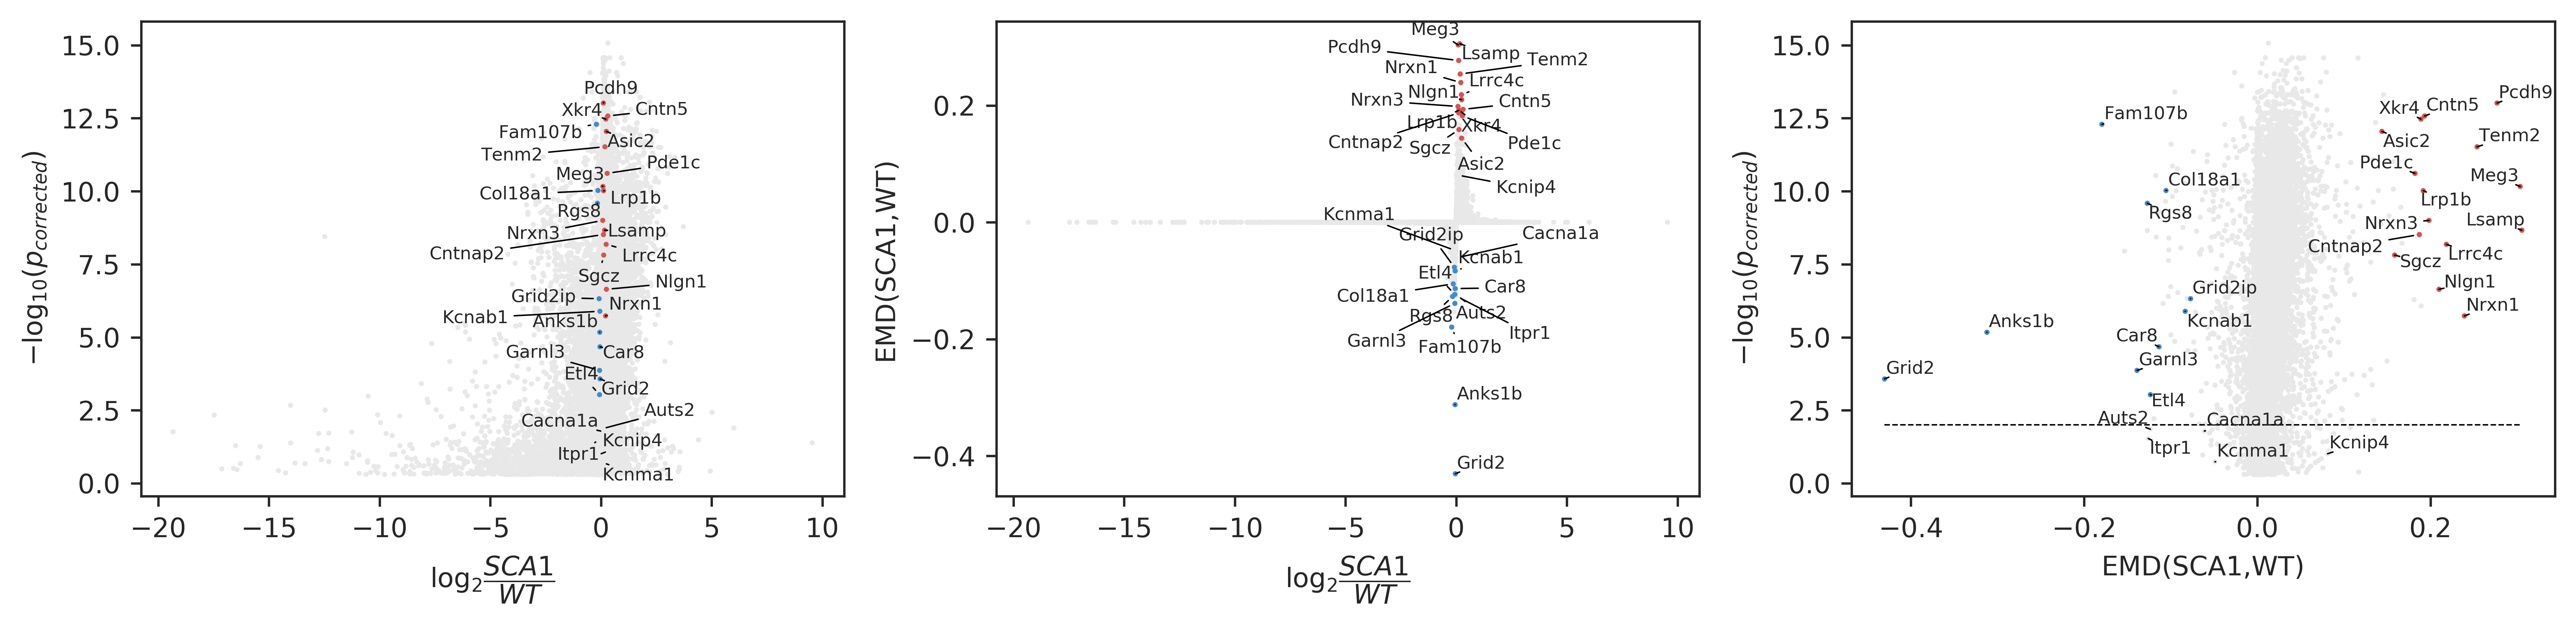

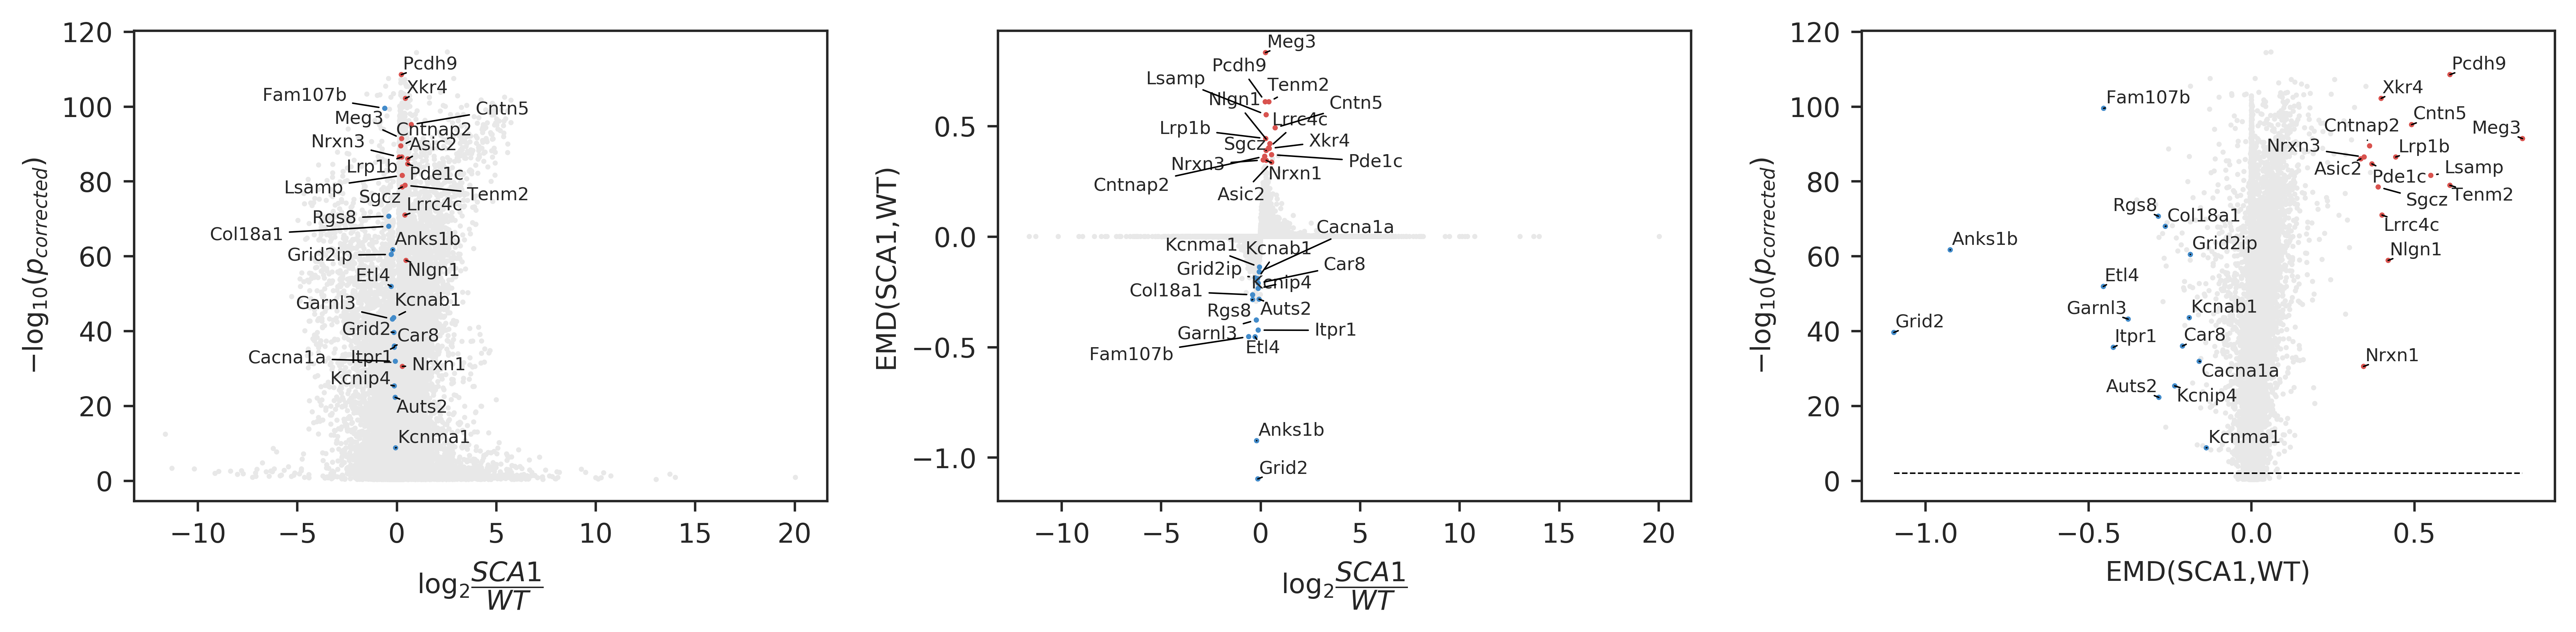

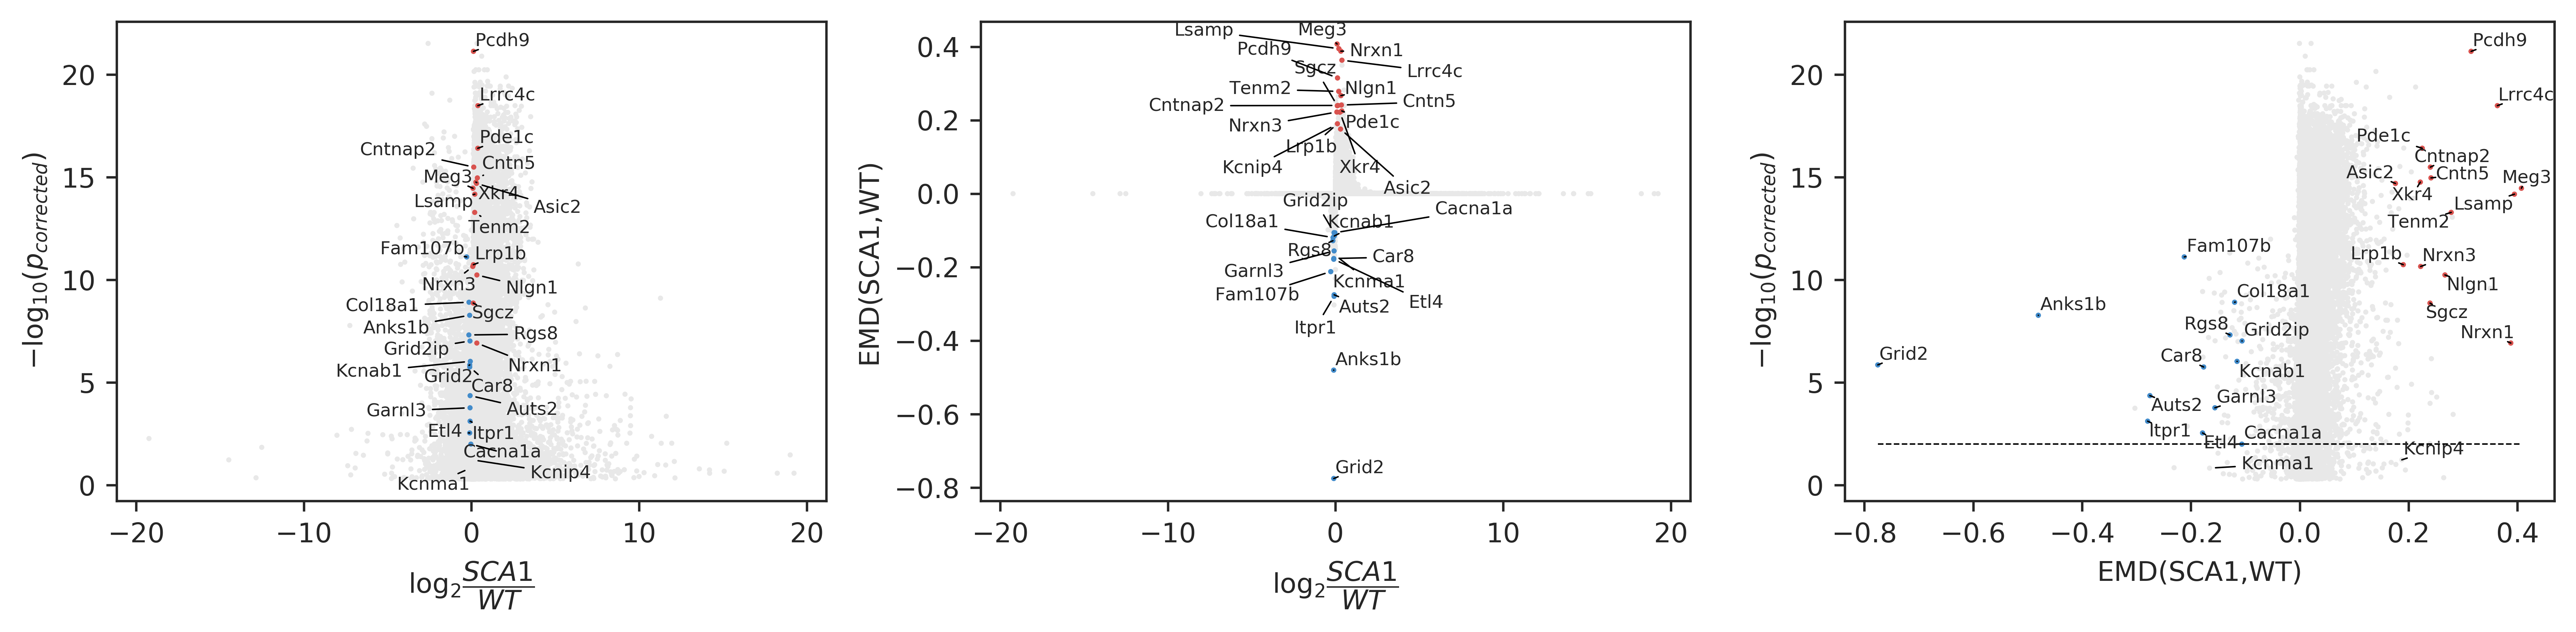

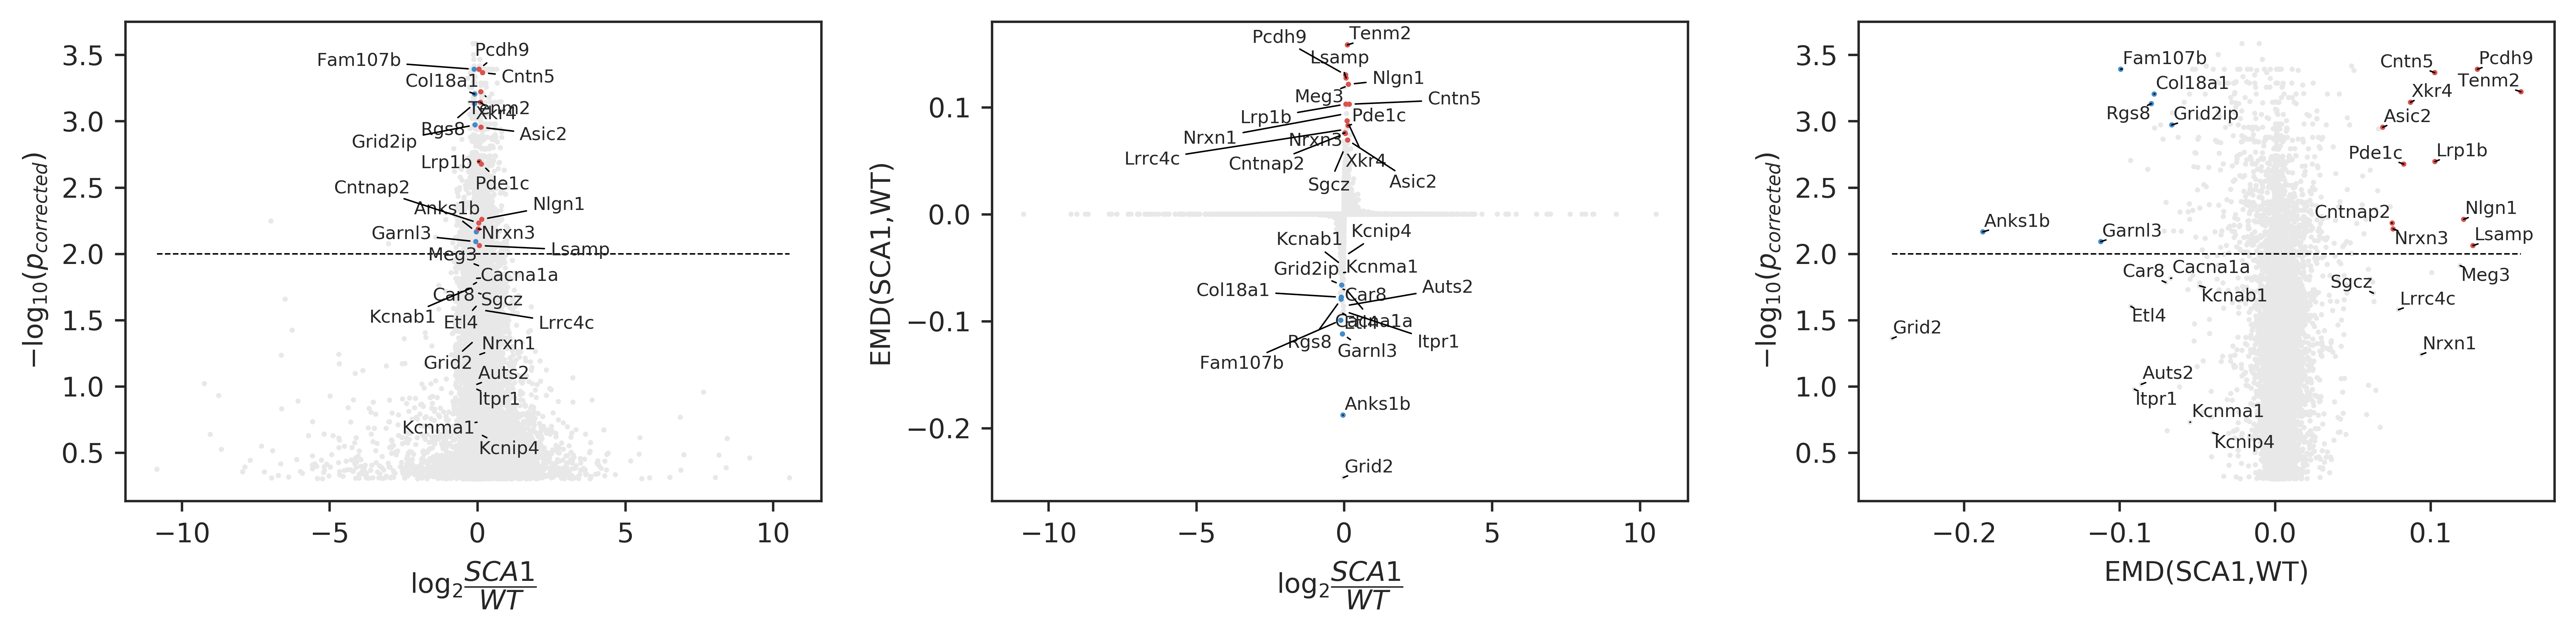

In [113]:
# mouse 
fname = 'mouse_PC'

dge = pd.DataFrame()
for t in mdata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
    start_t=time.time()
    tdata = sc.AnnData(mdata[mdata.obs['timepoint']==t,:])
    tdata=tdata[:,~tdata.var_names.isin(['Malat1'])]
    
    cluster='ctype'
    groups = ['Purkinje cell']#tdata.obs[cluster].unique() # subset from which adata.obs var, `cluster=this var`?
    for i in groups :
        start = time.time()
        X = tdata.layers['imputed_bbknn'][(tdata.obs[cluster]==i) & (tdata.obs['genotype']=='WT') ,:]
        X_mut = tdata.layers['imputed_bbknn'][(tdata.obs[cluster]==i) & (tdata.obs['genotype']=='SCA1') ,:]

        p = mwu(X,X_mut,tdata.var_names) # directionality doesn't matter
        emd = scprep.stats.differential_expression(X_mut,X,
                                                   measure = 'emd',
                                                   direction='both', 
                                                   gene_names=tdata.var_names,
                                                   n_jobs=-1)
        emd['Gene']=emd.index
        emd=emd.drop(columns='rank')
        fc = log2aveFC(X_mut,X,tdata.var_names.to_list())
        gene_mismatch = fc['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            fc = fc.loc[gene_mismatch,:]
            warnings.warn('Warning: {} genes dropped due to p-val NA.'.format((gene_mismatch==False).sum()))
        dt = pd.merge(p,fc,how='left',on="Gene")
        gene_mismatch = emd['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            emd = emd.loc[gene_mismatch,:]
        dt = pd.merge(dt,emd,how='left',on='Gene')
        dt['Cell type']=[i]*dt.shape[0]
        dt['timepoint']=[t]*dt.shape[0]
        dt['nlog10pvalcorrected']=(-1)*np.log10(dt['pval_corrected'])

        ## aesthetics
        cmap_volcano={'N.S.':'#E8E8E866','Up':'#d9534f','Down':'#428bca','B.H. cutoff':'#E8E8E8'}
        bonferonni_fulldata=0.01/3e5 # pval threshold
        dt['Significance']=['N.S.']*dt.shape[0]
        dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
        #     dt['Significance'][(dt['log2FC']>=1) & (dt['pval_corrected']<=bonferonni_fulldata)]='up'
        #     dt['Significance'][(dt['log2FC']<=-1) & (dt['pval_corrected']<=bonferonni_fulldata)]='down'
        dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Up'
        dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Down'

        ## plot
        fig,ax=plt.subplots(1,3,figsize=(12,3))
        p0=sns.scatterplot(x='log2FC',y='nlog10pvalcorrected',
                          data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                           ax=ax[0],s=3,edgecolor='none',
                          palette=cmap_volcano,hue='Significance',legend=False,
                          rasterized=True)
        p0top=sns.scatterplot(x='log2FC',y='nlog10pvalcorrected',
                          data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],ax=ax[0],s=3,edgecolor='none',
                          palette=cmap_volcano,hue='Significance',legend=False,
                          rasterized=True)
        ax[0].plot([dt['log2FC'].min(),dt['log2FC'].max()],
                (-1)*np.log10([0.01,0.01]),
                'k--',lw=0.5) # BH cut off
        ax[0].set(xlabel='$\log_2 \dfrac{SCA1}{WT}$',ylabel='$-\log_{10}$($p_{corrected}$)')

        p1=sns.scatterplot(x='log2FC',y='emd',
                          data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                           ax=ax[1],s=3,edgecolor='none',
                          palette=cmap_volcano,hue='Significance',legend=False,
                          rasterized=True)
        p1top=sns.scatterplot(x='log2FC',y='emd',
                          data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                           ax=ax[1],s=3,edgecolor='none',
                          palette=cmap_volcano,hue='Significance',legend=False,
                          rasterized=True)
        ax[1].set(xlabel='$\log_2 \dfrac{SCA1}{WT}$',ylabel='EMD(SCA1,WT)')

        p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                          data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                           ax=ax[2],s=3,edgecolor='none',
                          palette=cmap_volcano,hue='Significance',legend=False,
                          rasterized=True)
        p2top=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                          data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                           ax=ax[2],s=3,edgecolor='none',
                          palette=cmap_volcano,hue='Significance',legend=False,
                          rasterized=True)
        ax[2].plot([dt['emd'].min(),dt['emd'].max()],
                (-1)*np.log10([0.01,0.01]),
                'k--',lw=0.5) # BH cut off
        ax[2].set(xlabel='EMD(SCA1,WT)',ylabel='$-\log_{10}$($p_{corrected}$)')

        fig.tight_layout()

        ## annotate
        if False :
            ### pick genes w/mutual highest rank
            idx_up = (dt['nlog10pvalcorrected'][dt['Significance']=='up'].rank(ascending=False)+dt['log2FC'][dt['Significance']=='up'].rank(ascending=False)).sort_values().index[0:10]
            g_up = tdata.var_names[idx_up]
            g_up_x = dt['log2FC'][idx_up].to_list()
            g_up_y = dt['nlog10pvalcorrected'][idx_up].to_list()
            idx_down = (dt['nlog10pvalcorrected'][dt['Significance']=='down'].rank(ascending=False)+dt['log2FC'][dt['Significance']=='down'].rank(ascending=True)).sort_values().index[0:10]
            g_down = tdata.var_names[idx_down]
            g_down_x = dt['log2FC'][idx_down].to_list()
            g_down_y = dt['nlog10pvalcorrected'][idx_down].to_list()

            texts = [ax.text(g_up_x[i], g_up_y[i], g,fontsize=4) for i,g in enumerate(g_up)]
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.25))
            texts_down = [ax.text(g_down_x[i], g_down_y[i], g,fontsize=4) for i,g in enumerate(g_down)]
            adjust_text(texts_down,arrowprops=dict(arrowstyle="-", color='k', lw=0.25))
        else : 
            ### manually pick 
            idx_g={}
            for g in genes_volcano[fname]: # match fname with dict key
                idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

            texts = [ax[0].text(dt['log2FC'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax[0])

            texts = [ax[1].text(dt['log2FC'][i],dt['emd'][i],g,fontsize=6) for g,i in idx_g.items()]
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax[1])

            texts = [ax[2].text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
            adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax[2])

        if True :
            # save plot
            fig.savefig(os.path.join(pfp,'volcano_{}_t{}.pdf'.format(fname,t)),dpi=300, bbox_inches='tight')
            
        dge = dge.append(dt, ignore_index=True)
        print('... computed in {:.2f}-s'.format(time.time()-start))
    print('\nFinished timepoint {} in {:.2f}-min'.format(t,(time.time()-start_t)/60))
    del tdata
if True :
    # save volcano plot data
    dge.to_csv(os.path.join(pfp,'volcano_'+fname+'.csv'),index=False)
